# Programming Exercise 4: Learning with Latent Variables

In [207]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(1)

## Problem 1

Suppose we have a set of observations $(x_1, \dots , x_N)$. Our goal is to model that set using a mixture of Gaussians. In
order to do that, we maximize the likelihood function $p(x_1, \dots , x_N | π, µ, Σ)$ (or the log-likelihood) with the help
of the expectation-maximization (EM) algorithm. Let’s illustrate the EM algorithm for a mixture of two Gaussians.

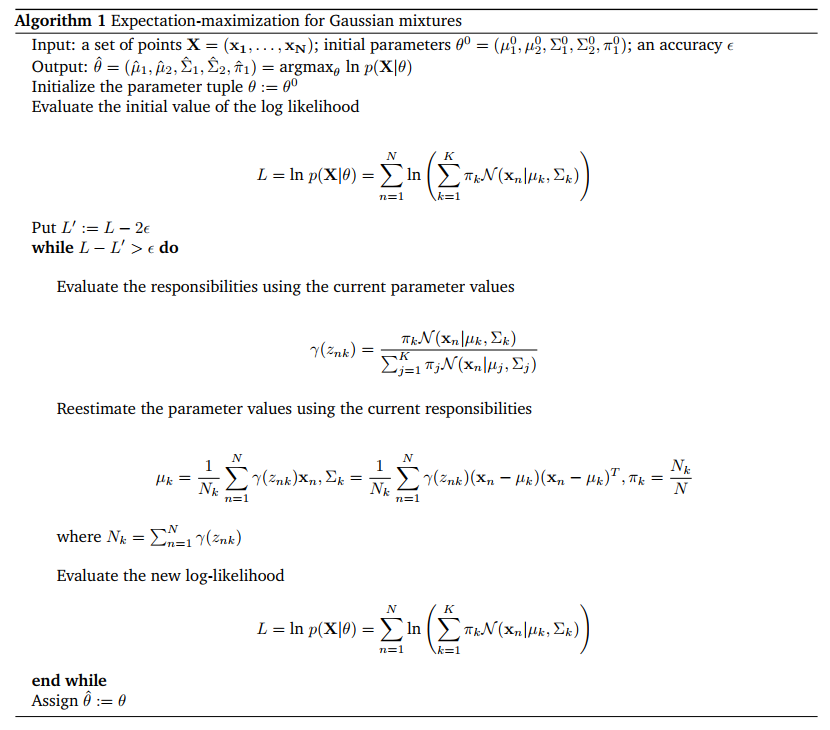

### 1. Generation of the Dataset

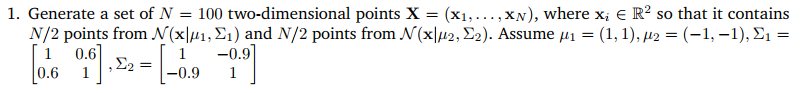

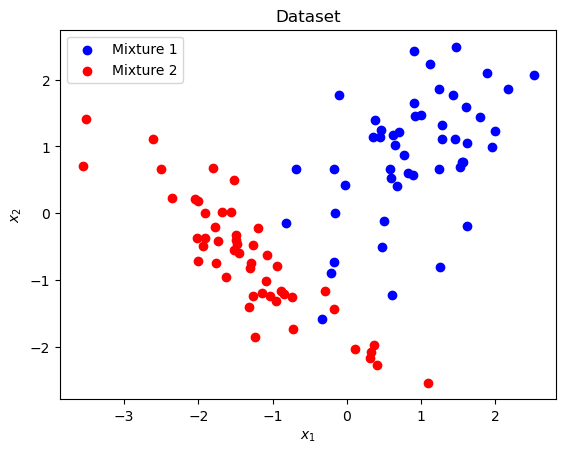

In [208]:

mean1 = np.array([1,1])
mean2 = np.array([-1,-1])

cov_matrix1 = np.array([[1, 0.6], [0.6, 1]])
cov_matrix2 = np.array([[1, -0.9], [-0.9, 1]])

p1 = 0.5

N = 100

true_parameters = [mean1, mean2, cov_matrix1, cov_matrix2, 0.5]
samples1 = np.random.multivariate_normal(mean1, cov_matrix1, size=N//2)
samples2 = np.random.multivariate_normal(mean2, cov_matrix2, size=N//2)

plt.scatter(x=samples1[:, 0], y=samples1[:, 1], color='blue', label="Mixture 1")
plt.scatter(x=samples2[:, 0], y=samples2[:, 1], color='red', label="Mixture 2")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Dataset")
plt.legend()
plt.show()

dataset = np.concatenate((samples1, samples2), axis=0)

### 2. Implementation of EM-algorithm and Results
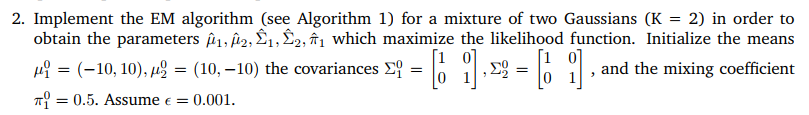

In [209]:
def gamma(dataset, parameters_estimate):
    '''
    Function responsible for calculating the coefficients gamma(Znk) values in the EM algorithm.
    The return is a matrix 2xN. The first row contains the coefficients gamma(Znk) of all points for the first mixture (k = 1).
    The second row gives the same, but for the mixture 2.
    
    Argument 'parameters_estimate' must be tuple of the form (mean1, mean2, sigma1, sigma2, p1).
    Means must be numpy arrays with size (2,)

    '''
    [mean1_estimated, mean2_estimated, cov1_estimated, cov2_estimated, p1] = parameters_estimate
    
    p2 = 1 - p1
    
    estimated_likelihood_mix1_array =  p1*stats.multivariate_normal.pdf(dataset, mean1_estimated, cov1_estimated)
    estimated_likelihood_mix2_array =  p2*stats.multivariate_normal.pdf(dataset, mean2_estimated, cov2_estimated)
    
    gamma1_array = estimated_likelihood_mix1_array/(estimated_likelihood_mix1_array + estimated_likelihood_mix2_array)
    gamma2_array = estimated_likelihood_mix2_array/(estimated_likelihood_mix1_array + estimated_likelihood_mix2_array)
    
    gamma_matrix = np.vstack((gamma1_array, gamma2_array))
    
    return gamma_matrix

def reestimate_paramaters(dataset, parameters):
    '''
    This function returns the new tuple (mean1, mean2, sigma1, sigma2, p1)
    Means are given with numpy arrays with size (2,)
    '''
    gamma_coefs_array = gamma(dataset, parameters)
    
    # Sum is performed, separately in each mixture, over coefficients gamma_n from n = 1 to n = N
    # N1 is such sum for mixture 1 and N2 for mixture 2
    [N1, N2] = gamma_coefs_array.sum(axis=1)
    
    new_p1_estimate = N1/N
    
    # Updates of the means are performed together by exploring matrix notations
    # First element of 'new_means_estimate_array' corresponds to mixture 1
    new_means_estimate_array = (gamma_coefs_array @ dataset)
    
    new_mean1_estimate = new_means_estimate_array[0]/N1
    new_mean2_estimate = new_means_estimate_array[1]/N2
    
    # Subtraction of the mean vector is broadcasted for all points in the dataset
    dataset_minus_mean1 = dataset - new_mean1_estimate
    dataset_minus_mean2 = dataset - new_mean2_estimate
    
    # The n-th row of the following arrays stores the matrix (x_n - mean_k)(x_n - mean_k).T
    outer_product_dataset_mean1 = np.zeros((100, 2, 2))
    outer_product_dataset_mean2 = np.zeros((100, 2, 2))
    
    for i in range(N):
        v1 = dataset_minus_mean1[i]
        v2 = dataset_minus_mean2[i]
        
        outer_product_dataset_mean1[i] = np.outer(v1, v1)
        outer_product_dataset_mean2[i] = np.outer(v2, v2)
    
    gamma_n_1 = gamma_coefs_array[0, :]
    gamma_n_2 = gamma_coefs_array[1, :]
    
    gamma_n_1_reshaped = gamma_n_1[:, np.newaxis, np.newaxis]
    gamma_n_2_reshaped = gamma_n_2[:, np.newaxis, np.newaxis]
    
    # Updates of Covariance Matrices are performed separately
    new_cov_matrix1_estimate = (1/N1) * np.sum(gamma_n_1_reshaped * outer_product_dataset_mean1, axis=0)
    new_cov_matrix2_estimate = (1/N2) * np.sum(gamma_n_2_reshaped * outer_product_dataset_mean2, axis=0)
    
    return (new_mean1_estimate, new_mean2_estimate, new_cov_matrix1_estimate, new_cov_matrix2_estimate, new_p1_estimate)

def log_likelihood(dataset, parameters):
    '''
    This function returns the log-likelihood for the given estimated parameters.
    Dataset must be a matrix Nx2. Each row of it must correspond to a sample point.
    '''
    [mean1, mean2, cov1, cov2, p1] = parameters
    p2 = 1 - p1
    
    # the method multivariate_normal.pdf() calculates the Gaussian PDF over the points stored in the rows of the 'dataset' matrix (Nx2) 
    inner_term_array = p1*stats.multivariate_normal.pdf(dataset, mean1, cov1) + p2*stats.multivariate_normal.pdf(dataset, mean2, cov2)
    
    return np.log(inner_term_array).sum()

def expectation_maximization_gaussian_mixtures(dataset, initial_parameters, epsilon):
    '''
    Function returns obje
    '''
    initial_L = log_likelihood(dataset, initial_parameters)
    L = initial_L
    L_line =  L - 2*epsilon
    parameters_estimate = initial_parameters
    
    num_iterations = 0
         
    while (L - L_line > epsilon):
        num_iterations += 1
        parameters_estimate = reestimate_paramaters(dataset, parameters_estimate)
        L_line = L
        L = log_likelihood(dataset, parameters_estimate)
    
    
    return {"parameters": parameters_estimate, "log_likelihood": L, "initial_parameters": initial_parameters, "iterations": num_iterations, "initial_log_likelihood": initial_L}

In [210]:
def print_parameters(parameters):
    '''
    Argument 'parameters_estimate' must be tuple of the form (mean1, mean2, sigma1, sigma2, p1).
    '''
    [mean1, mean2, cov_matrix1, cov_matrix2, p1] = parameters
    p2 = 1 - p1
    
    print(f"Mean1 = {mean1}", f"Mean2 = {mean2}")
    print(f"P1 = {p1}", f"P2 = {p2}")
    print("Covariance Matrix 1 = ")
    print(cov_matrix1)
    print("Covariance Matrix 2 = ")
    print(cov_matrix2)

def print_results(results):
    num_iterations = results["iterations"]
    L = results["log_likelihood"]
    initial_L = results["initial_log_likelihood"]
    
    print("INITIAL PARAMETERS")
    print_parameters(results["initial_parameters"])
    
    print("")
    print("")
    
    print(f"FINAL PARAMETERS AFTER {num_iterations} ITERATIONS")
    print_parameters(results["parameters"])
    
    print("")
    print("")
    
    print(f"INITIAL LOG-LIKELIHOOD: {initial_L}")
    print(f"FINAL LOG-LIKELIHOOD: {L}")

def print_ideal_results(true_parameters, dataset):
    print("TRUE PARAMETERS")
    print_parameters(true_parameters)
    
    print("")
    print("")
    
    print(f"TRUE LOG-LIKELIHOOD: {log_likelihood(dataset, true_parameters)}")

In [211]:
def generate_points_for_ellipse(mean, cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    radius_x1 = np.sqrt(eigenvalues[0])
    radius_x2 = np.sqrt(eigenvalues[1])
    
    t_range = np.linspace(0, 2*np.pi, 100)
    
    cos_t_range = np.cos(t_range)
    sin_t_range = np.sin(t_range)
    
    points_centered = np.column_stack((radius_x1 * cos_t_range, radius_x2 * sin_t_range))
    
    points_rotated = np.dot(points_centered, eigenvectors.T)
    
    # return points_rotated
    return points_rotated + mean

#### Execution of EM-algorithm for the initial estimations

In [212]:
initial_mean1 = np.array([0, 10])
initial_mean2 = -initial_mean1
initial_cov_matrix1 = np.identity(2)
initial_cov_matrix2 = np.identity(2)
initial_p1 = 0.5

initial_parameters = [initial_mean1, initial_mean2, initial_cov_matrix1, initial_cov_matrix2, initial_p1]
    
results = expectation_maximization_gaussian_mixtures(dataset, initial_parameters, 0.001)

#### Results

In [213]:
print_results(results)

INITIAL PARAMETERS
Mean1 = [ 0 10] Mean2 = [  0 -10]
P1 = 0.5 P2 = 0.5
Covariance Matrix 1 = 
[[1. 0.]
 [0. 1.]]
Covariance Matrix 2 = 
[[1. 0.]
 [0. 1.]]


FINAL PARAMETERS AFTER 9 ITERATIONS
Mean1 = [0.97975868 1.02467862] Mean2 = [-1.22973298 -0.71180792]
P1 = 0.46025016014566006 P2 = 0.5397498398543399
Covariance Matrix 1 = 
[[0.48247293 0.20112127]
 [0.20112127 0.59890585]]
Covariance Matrix 2 = 
[[ 0.85907088 -0.68953667]
 [-0.68953667  0.74779797]]


INITIAL LOG-LIKELIHOOD: -4398.666082869328
FINAL LOG-LIKELIHOOD: -269.62725468060387


#### Ideal Results

In [214]:
print_ideal_results(true_parameters, dataset)

TRUE PARAMETERS
Mean1 = [1 1] Mean2 = [-1 -1]
P1 = 0.5 P2 = 0.5
Covariance Matrix 1 = 
[[1.  0.6]
 [0.6 1. ]]
Covariance Matrix 2 = 
[[ 1.  -0.9]
 [-0.9  1. ]]


TRUE LOG-LIKELIHOOD: -276.94722958225697


#### Sample Means and Sample Covariances of Each Mixture

In [215]:
sample_mean_mix1 = np.mean(samples1, axis=0)
sample_mean_mix2 = np.mean(samples2, axis=0)

sample_cov_mix1 = np.cov(samples1, rowvar=False)
sample_cov_mix2 = np.cov(samples2, rowvar=False)

print("Sample Mean and Sample Covariance for Each Mixture \n\n")
print_parameters((sample_mean_mix1, sample_mean_mix2, sample_cov_mix1 ,sample_cov_mix2, 0.5))

Sample Mean and Sample Covariance for Each Mixture 


Mean1 = [0.88423152 0.86944235] Mean2 = [-1.30985969 -0.69462177]
P1 = 0.5 P2 = 0.5
Covariance Matrix 1 = 
[[0.57440868 0.35522946]
 [0.35522946 0.86744792]]
Covariance Matrix 2 = 
[[ 0.84392261 -0.73157675]
 [-0.73157675  0.79944621]]


### 3. Graphical Results

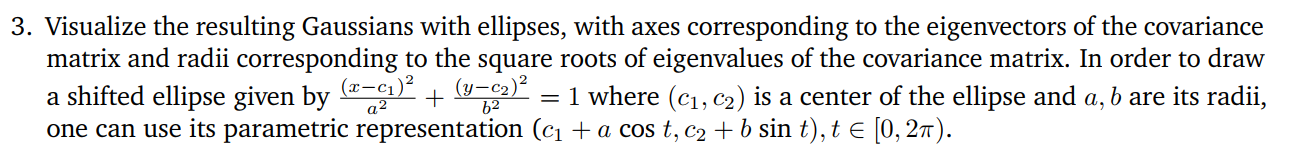

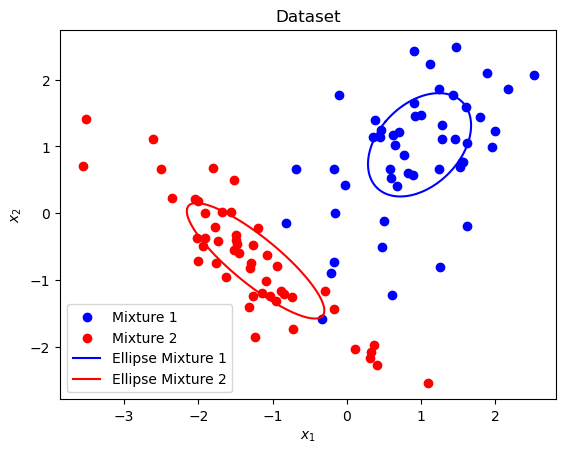

In [216]:
mean1_result = results["parameters"][0]
mean2_result = results["parameters"][1]
cov1_result = results["parameters"][2]
cov2_result = results["parameters"][3]


ellipse_points1 = generate_points_for_ellipse(mean1_result, cov1_result)
ellipse_points2 = generate_points_for_ellipse(mean2_result, cov2_result)

plt.scatter(x=samples1[:, 0], y=samples1[:, 1], color='blue', label="Mixture 1")
plt.scatter(x=samples2[:, 0], y=samples2[:, 1], color='red', label="Mixture 2")
plt.plot(ellipse_points1[:, 0], ellipse_points1[:, 1], color='blue', label="Ellipse Mixture 1")
plt.plot(ellipse_points2[:, 0], ellipse_points2[:, 1], color='red', label="Ellipse Mixture 2")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Dataset")
plt.legend()
plt.show()